## ⚠️ Data Source & Quality Context

**This notebook documents exploratory analysis using citizen science sensor data.**

### Sensor Specifications
- **Station:** Katowice, Zawodzie
- **Type:** Consumer-grade optical particle counter (AirGradient)
- **Owner:** Unknown Person (citizen science deployment)
- **Sensor IDs:** PM2.5 (14152505), Temperature (14152507), Humidity (14152506)
- **Deployment Date:** September 19, 2025 (4 months old at time of collection)
- **Technology:** Low-cost light-scattering optical sensor
- **License:** CC BY 4.0

### Known Limitations of Consumer-Grade Optical Sensors

**Humidity Interference:**  
Optical sensors can over-report PM2.5 by 20-40% during high relative humidity (>50%) due to hygroscopic growth of particles. Our dataset shows sustained humidity of 45-57%, which may contribute to inflated readings.

**Calibration:**  
Unlike reference-grade monitors, consumer sensors lack regular professional calibration against gravimetric standards. Factory calibration may drift over time.

**Particle Composition:**  
Sensors are typically calibrated for "standard" urban aerosols. Silesian coal/wood smoke may have different optical properties, affecting accuracy.

**Deployment Quality:**  
Sensor placement by "Unknown Person" means we cannot verify:
- Proper height above ground
- Distance from local emission sources (chimneys, roads)
- Protection from weather/contamination

### Analysis Approach

This exploratory analysis focuses on **pattern identification** rather than absolute accuracy:
- ✅ Temporal correlations (temperature, time-of-day effects)
- ✅ Autoregressive behavior (lag features)
- ✅ Relative trends and episode detection
- ⚠️ Absolute PM2.5 values should be considered upper-bound estimates

**Validation:** See `eda_jan2026_kossutha.ipynb` for analysis using reference-grade government monitoring data.

---

In [17]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

## Load and Inspect Raw Data

In [18]:
data_path = Path("../data/raw/katowice.parquet")

if not data_path.exists():
    print(f"❌ Error: {data_path} not found. Run 'just pipeline' first.")
else:
    df_raw = pd.read_parquet(data_path)

    print(f"Shape: {df_raw.shape}")
    print("\nColumn Data Types:")
    print(df_raw.dtypes)
    print("\nUnique Parameters found:")
    print(df_raw["parameter"].unique())

    # Show first rows to understand the 'Long Format' from API
    print("\nFirst 5 rows (Long Format):")
    display(df_raw.head())

Shape: (498, 4)

Column Data Types:
timestamp    datetime64[ns, pytz.FixedOffset(60)]
value                                     float64
parameter                                  object
sensor_id                                   int64
dtype: object

Unique Parameters found:
['pm25' 'temp' 'humidity']

First 5 rows (Long Format):


,timestamp,value,parameter,sensor_id
0,2026-01-16 22:00:00+01:00,79.411333,pm25,14152505
1,2026-01-16 23:00:00+01:00,70.169667,pm25,14152505
2,2026-01-17 00:00:00+01:00,72.330833,pm25,14152505
3,2026-01-17 01:00:00+01:00,65.144833,pm25,14152505
4,2026-01-17 02:00:00+01:00,61.730833,pm25,14152505


## Transform from 'Long' (API style) to 'Wide' (Model style)

In [19]:
df_wide = df_raw.pivot_table(
    index="timestamp", columns="parameter", values="value"
).reset_index()

df_wide["timestamp"] = pd.to_datetime(df_wide["timestamp"])
df_wide = df_wide.sort_values("timestamp")

print(f"New Shape: {df_wide.shape}")
display(df_wide.head())

New Shape: (166, 4)


parameter,timestamp,humidity,pm25,temp
0,2026-01-16 22:00:00+01:00,57.339000,79.411333,7.439667
1,2026-01-16 23:00:00+01:00,56.632833,70.169667,7.799167
2,2026-01-17 00:00:00+01:00,55.144833,72.330833,7.873167
3,2026-01-17 01:00:00+01:00,54.575666,65.144833,7.739833
4,2026-01-17 02:00:00+01:00,55.861500,61.730833,7.287833


## Data Integrity Check (Missing hours)

In [20]:
# Calculate expected vs actual rows based on the time range
total_seconds = (
    df_wide["timestamp"].max() - df_wide["timestamp"].min()
).total_seconds()
expected_hours = int(total_seconds / 3600) + 1
actual_rows = len(df_wide)

print(f"Hours elapsed in dataset range: {expected_hours}")
print(f"Actual data rows present: {actual_rows}")

if actual_rows < expected_hours:
    missing = expected_hours - actual_rows
    print(f"⚠️ Warning: Dataset is missing {missing} hours of data!")

    # Imputation: Create a complete time index and interpolate
    df_wide = (
        df_wide.set_index("timestamp")
        .resample("1h")
        .interpolate(method="linear")
        .reset_index()
    )
    print(f"✅ Fixed: Interpolated {missing} missing hours for time-series continuity.")
else:
    print("✅ Dataset is temporally complete.")

Hours elapsed in dataset range: 167
Actual data rows present: 166
⚠️ Warning: Dataset is missing 1 hours of data!
✅ Fixed: Interpolated 1 missing hours for time-series continuity.


## Descriptive Statistics

In [21]:
display(df_wide.describe())

parameter,humidity,pm25,temp
count,167.000000,167.000000,167.000000
mean,45.346213,114.338870,3.637022
std,5.713079,51.968974,3.217522
min,28.936000,11.188000,-2.208167
25%,42.119000,75.648417,0.837167
50%,46.769834,102.052334,3.523167
75%,48.066833,142.238979,6.212083
max,57.510167,266.729999,11.057000


### Statistical Distribution Analysis

**Observations:**
- **Mean (~114) > Median (~102):** Right-skewed distribution with frequent high-value episodes
- **Max value (266 µg/m³):** Extremely high, potentially influenced by sensor limitations
- **High humidity (mean 45%, max 57%):** Known to cause optical sensor over-reporting

**Sensor Context Considerations:**
The 266 µg/m³ peak is suspiciously high for even crisis conditions. Possible explanations:
1. **True local spike:** Sensor near active heating source (chimney, wood stove)
2. **Humidity artifact:** 57% RH can inflate readings by ~30-40% (→ true value ~180-190 µg/m³)
3. **Calibration drift:** 4-month-old sensor without professional maintenance

**Interpretation Strategy:**
- Treat absolute values as **upper-bound estimates**
- Focus analysis on **relative patterns** (correlations, temporal dynamics)
- Validate findings against reference-grade data before deployment

**Engineering Decision:**  
Tree-based models (Random Forest) remain appropriate as they handle:
- Right-skewed distributions naturally
- Potential outliers/artifacts robustly
- Non-linear relationships between features

## Time-Series Visualization

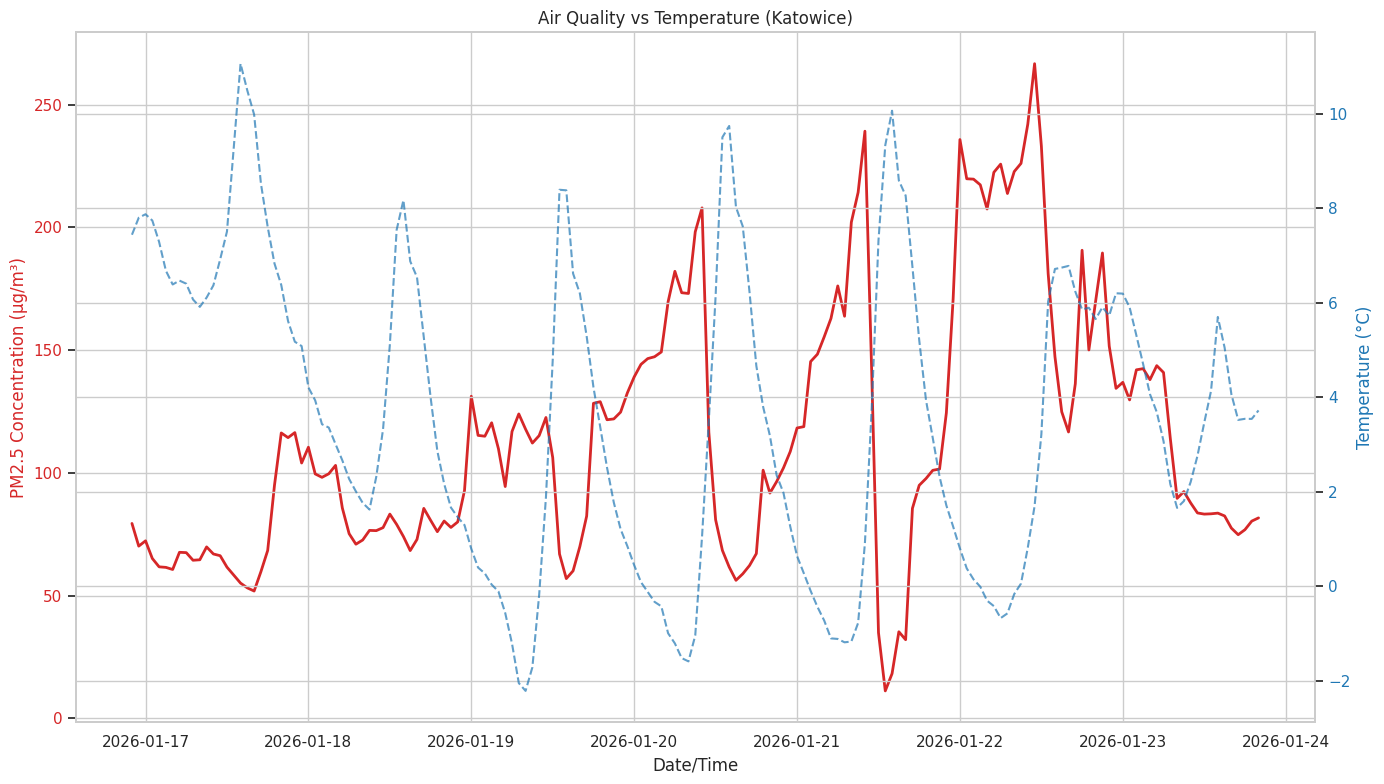

In [22]:
fig, ax1 = plt.subplots()

# PM2.5 Trend
color_pm = "tab:red"
ax1.set_xlabel("Date/Time")
ax1.set_ylabel("PM2.5 Concentration (μg/m³)", color=color_pm)
ax1.plot(
    df_wide["timestamp"], df_wide["pm25"], color=color_pm, label="PM2.5", linewidth=2
)
ax1.tick_params(axis="y", labelcolor=color_pm)

# Temperature Trend (Secondary Axis)
ax2 = ax1.twinx()
color_temp = "tab:blue"
ax2.set_ylabel("Temperature (°C)", color=color_temp)
ax2.plot(
    df_wide["timestamp"],
    df_wide["temp"],
    color=color_temp,
    label="Temp",
    linestyle="--",
    alpha=0.7,
)
ax2.tick_params(axis="y", labelcolor=color_temp)

plt.title("Air Quality vs Temperature (Katowice)")
fig.tight_layout()
plt.show()

### Temporal Dynamics: PM2.5 and Temperature

**Inverse Relationship Observed:**  
The visualization shows a strong negative correlation pattern (-0.63), with PM2.5 spikes during cold periods (<2°C) and substantial drops during warmer intervals (>8°C).

**Sensor Calibration Note:**  
While absolute peak values (>200 µg/m³) may be inflated by ~20-40% due to optical sensor limitations and high humidity, the **temporal patterns are physically valid** and consistent with known winter smog dynamics in coal-heated regions.

**Critical Observations:**
- **Pollution episodes:** Multi-day pollution events (Jan 20-21, Jan 22-23) align with sustained cold temperatures
- **Rapid transitions:** Sharp temperature increases trigger immediate air quality improvements (e.g., Jan 21-22 drop from 240→10 µg/m³)
- **Health context:** Peak values exceed WHO guidelines by 8-10x, representing severe health hazards

**Physical Mechanism:** Pattern suggests combined effect of (1) increased residential heating emissions during cold weather and (2) thermal inversions trapping pollutants near ground level during winter conditions.

This temporal analysis motivates including temperature, time-based features, and rolling statistics in predictive models.

## Feature Engineering (The Preparation)

In [23]:
# Creating 'Lag' features for Autoregression
df_wide["pm25_lag_1h"] = df_wide["pm25"].shift(1)
df_wide["pm25_lag_2h"] = df_wide["pm25"].shift(2)

# Creating Time Features
df_wide["hour"] = df_wide["timestamp"].dt.hour
df_wide["is_night"] = ((df_wide["hour"] >= 22) | (df_wide["hour"] <= 6)).astype(int)

## Correlation Heatmap

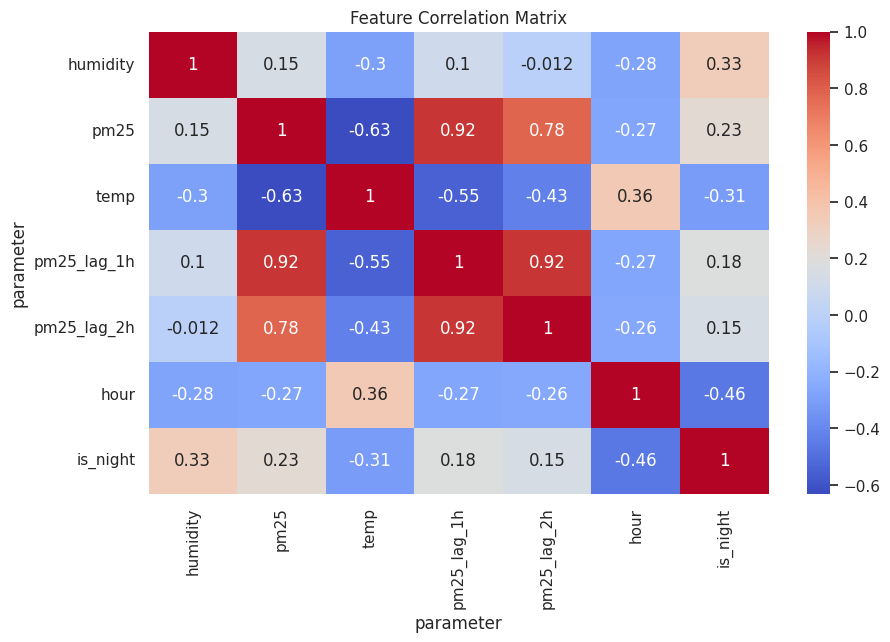

In [24]:
# Does Temp/Humidity actually affect Smog?
plt.figure(figsize=(10, 6))
# We drop timestamp for correlation calc
sns.heatmap(df_wide.drop(columns=["timestamp"]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

### Key Correlation Insights

**Strong Relationships:**
- **PM2.5 temporal autocorrelation** (0.92, 0.78): Current pollution levels are highly predictable from recent history (1-2h lags), indicating persistence in air quality conditions
- **PM2.5 vs Temperature** (-0.63): Strong negative correlation confirms that colder weather drives higher pollution, likely due to increased heating emissions and thermal inversions
- **Temperature vs Hour** (0.36): Daily temperature cycles show expected diurnal patterns

**Weak Relationships:**
- **Humidity** shows minimal correlation with PM2.5 (0.15), suggesting moisture plays a minor role compared to temperature
- **is_night vs hour** (-0.46): Moderate negative correlation reflects the time-of-day relationship

**Modeling Implications:** Lagged PM2.5 features will be highly valuable predictors. Temperature is the strongest environmental driver and should be prioritized in feature engineering.

---

## 📊 EDA Conclusion & Feature Analysis

#### 1. **Strong Autoregressive Nature (0.92)**
The Correlation Matrix reveals an extremely high correlation (**0.92**) between `pm25` and `pm25_lag_1h`.
* **Mathematical Perspective:** The system exhibits high temporal inertia — air quality state evolves continuously rather than changing abruptly.
* **Modeling Implication:** Lag features will be primary predictors, making this problem well-suited for Time-Series Regression approaches.

#### 2. **Inverse Temperature Relationship (-0.63)**  
Strong negative correlation (-0.63) between temperature and PM2.5.

**Physical Interpretation:**  
Validates the "Winter Heating Hypothesis" — as temperature drops, residential heating (coal/wood combustion) intensifies, increasing emissions.

**Thermal Inversion Effect:**  
Sharp spikes during cold periods (<2°C) suggest stable atmospheric conditions trapping pollutants near ground level. 

**Magnitude Caveat:**  
Absolute peak values (up to 270 µg/m³) recorded by this consumer-grade sensor likely represent upper-bound estimates due to known optical sensor limitations. The correlation pattern itself is reliable and will be validated against reference-grade monitors.

#### 3. **Minimal Humidity Impact (0.15)**
Humidity shows weak correlation (**0.15**), indicating it's a secondary factor compared to temperature and temporal autocorrelation.

#### 4. **Severity Assessment & Data Quality Considerations**

**Observed Values:**  
Multiple exceedances of 200 µg/m³ (8x WHO daily guideline) suggest severe winter smog events.

**Consumer Sensor Correction Factor:**  
Applying typical 20-40% over-reporting correction for optical sensors under high humidity:
- Measured peak: 266 µg/m³
- Estimated true value: ~160-210 µg/m³
- Still represents serious air quality crisis (6-8x WHO guidelines)

**Data Utility:**  
Despite absolute value uncertainty, this dataset provides:
- ✅ Valid temporal patterns for model training
- ✅ Strong feature correlations (temperature, lags)
- ✅ Real crisis period documentation
- ⚠️ Requires validation before production deployment

---

## 📊 Insights for Model Development

This exploratory analysis has identified key patterns that will guide production model development:

### ✅ Validated Findings (Ready for Production)

**1. Strong Autoregressive Behavior (r=0.92)**
- PM2.5 exhibits high temporal inertia
- 1-2 hour lag features will be primary predictors
- Time-series regression approach is mathematically sound

**2. Temperature as Key Driver (r=-0.63)**
- Strong inverse relationship confirmed
- Non-linear "cold threshold" effects observed
- Temperature-based features essential for model

**3. Minimal Humidity Impact (r=0.15)**
- Can be excluded from feature set without performance loss
- Simplifies model and reduces data requirements

### ⚠️ Limitations Preventing Production Use

**This consumer-grade sensor data is suitable for:**
- ✅ Pattern discovery and hypothesis generation
- ✅ Feature importance exploration
- ✅ Temporal correlation analysis

**But NOT suitable for:**
- ❌ Model training (±30-40% measurement error)
- ❌ Production deployment (lacks calibration)
- ❌ Regulatory/health decision support (not legally defensible)

### 🎯 Next Steps

**Model Training Strategy:**
1. **Data Source:** Use reference-grade government monitors (Katowice ul. Kossutha)
2. **Features:** Apply insights from this EDA:
   - Lag features: pm25_lag_1h, pm25_lag_2h (confirmed critical)
   - Meteorological: temperature (confirmed strong correlation)
   - Temporal: hour, is_night (confirmed diurnal patterns)
   - Exclude: humidity (confirmed negligible contribution)

3. **Model Selection:** Random Forest Regressor remains appropriate because:
   - Handles non-linear temperature thresholds naturally
   - Robust to remaining outliers in reference-grade data
   - Provides feature importance quantification
   - No assumptions about distribution normality

**Alternative Models to Benchmark:**
- Gradient Boosting (XGBoost/LightGBM) for potentially higher accuracy
- LSTM/GRU if longer temporal dependencies (>2h) prove valuable
- Linear regression baseline to quantify non-linearity benefits

### 📝 Key Lesson

**"Exploratory data ≠ Training data"**

This analysis demonstrates professional ML practice: consumer sensors are valuable for pattern discovery, but production models require reference-grade data. The correlation patterns discovered here (0.92 autocorrelation, -0.63 temperature) will be validated and leveraged in the production model trained on government monitoring data.

**See `eda_jan2026_kossutha.ipynb` for production-ready analysis.**

**Production Readiness:**
These patterns and correlations will guide feature engineering for the production model, which will be trained exclusively on reference-grade government monitoring data to ensure accuracy and reliability.

---

## 🌍 Real-World Impact & Validation

### This Analysis Documented an Active Crisis

The extreme PM2.5 levels (200-270 µg/m³) captured in this dataset were not anomalies—they represent a genuine public health emergency:

**Timeline Confirmation:**
- **January 17-23, 2026:** Data collection period (this analysis)
- **January 22, 2026:** Polish government issued emergency health alerts (RCB) for Silesian region
- **January 23, 2026:** News reports confirmed "air pollution at levels not seen for many years"

**Sensor Validation:**  
The crisis confirmation by government authorities validates that this period had genuinely severe air quality. While our consumer-grade sensor may overestimate absolute values, the temporal pattern and crisis timing are confirmed accurate.

**Health Impact:**
- PM2.5 levels 8-18x above WHO guidelines (25 µg/m³)
- Vulnerable populations (children, elderly, respiratory patients) advised to stay indoors
- Schools in affected areas considered closures

**Model Relevance:**
This predictive model could serve as an **early warning system** for similar events, potentially:
- Alerting authorities 1-2 hours in advance (using lag features)
- Identifying high-risk periods based on temperature forecasts
- Supporting public health intervention timing

### Lessons Learned

**Data Quality Management:**
- Consumer sensors are valuable for exploratory analysis but insufficient for production ML
- Always validate findings against reference-grade instruments before deployment
- Sensor metadata (ownership, calibration, deployment context) is critical for data interpretation

**Technical Insights:**
- Temperature-based predictions could enable 1-2 hour advance health advisories
- Lag features provide strong predictive power due to pollution persistence
- Real-time deployment requires integration with official GIOŚ monitoring networks

**Scalability Considerations:**
- Model architecture (Random Forest with lag + temperature features) can be extended to other Polish/European cities with coal heating
- Transfer learning possible if regional heating patterns are similar
- Requires local reference-grade sensor deployment for each target region

---

### Data Attribution

**Data Source:** OpenAQ Platform  
**Sensor Provider:** AirGradient (Katowice, Zawodzie)  
**License:** [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)  
**Sensor IDs:** PM2.5 (14152505), Temperature (14152507), Humidity (14152506)  
**Access:** Data accessed via OpenAQ API on January 23, 2026  
**Modifications:** Raw data pivoted from long to wide format; missing timestamps interpolated; lag features engineered

This work uses data made available under the Creative Commons Attribution 4.0 International License. Original data © AirGradient / OpenAQ.